## Урок 6

### Градиентный бустинг

####  1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.datasets import load_diabetes

In [2]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [3]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [4]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [5]:
def bias(y, z):
    return (y - z)

In [6]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [7]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [8]:
def get_error_plot(n_trees, max_depth, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.title(f'кол-во деревьев {n_trees}, глубина {max_depth}')
    plt.ylim(0, 10000)
    plt.grid()
    plt.show()

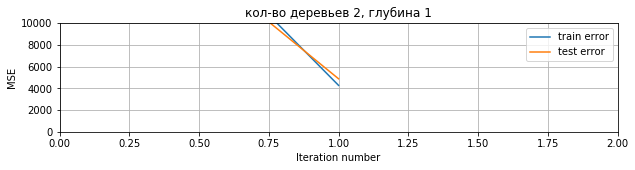

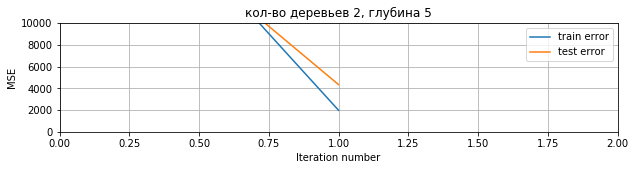

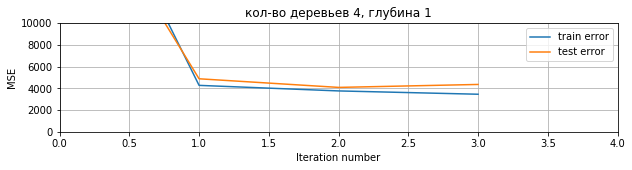

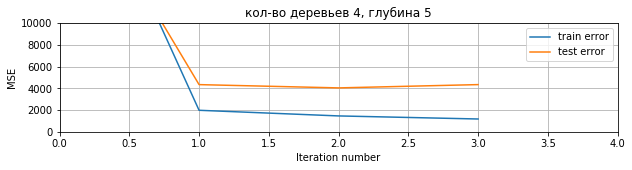

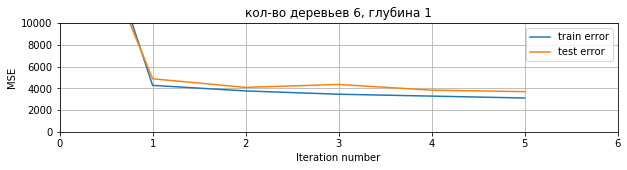

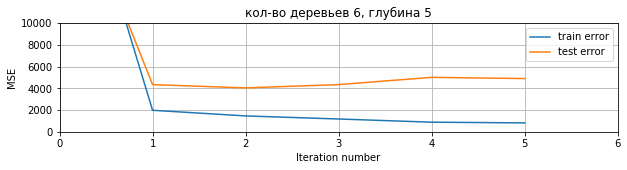

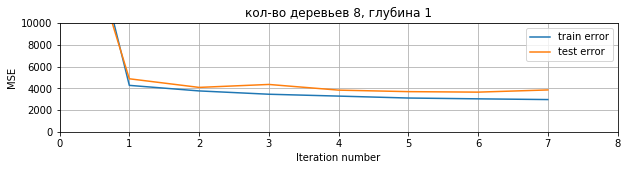

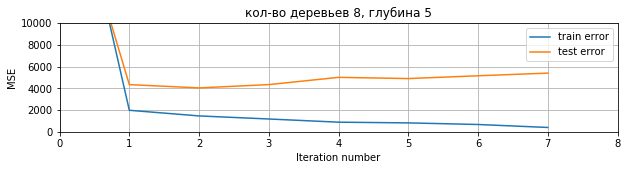

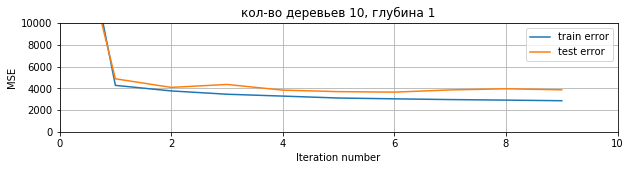

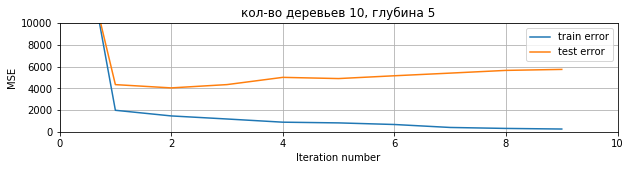

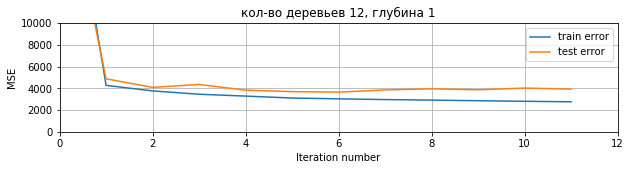

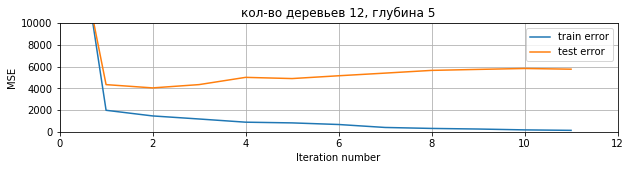

In [9]:
for n_trees in range(2, 14, 2):
    eta = 1
    coefs = [1] * n_trees
    for max_depth in [1, 5]:        
        trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        if max_depth == 1 or max_depth == 5:
            plt.figure(figsize = (10, 2))
            get_error_plot(n_trees, max_depth, train_errors, test_errors)

In [10]:
from tqdm import tqdm
train_list = []
test_list = []
b_n_trees = 0
b_m_depth = 0
b_eta = 0
b_train = 0
b_test = 0

for n_trees in tqdm(range(1, 11)): 
    for max_depth in range(1, 11):
        for eta in [1, 0.1, 0.01, 0.001, 0.0001]:
            trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
            train_list.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_list.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

            if train_list[-1] == min(train_list) and test_list[-1] == min(test_list):
                b_n_trees = n_trees
                b_m_depth = max_depth
                b_eta = eta
                b_train = train_list[-1]
                b_test = test_list[-1]
print(f"Лучшее кол-во деревьев: {b_n_trees}, Лучшая глубина: {b_m_depth}, Лучший шаг: {b_eta}") 
print(b_train, b_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:16<00:00, 49.66s/it]

Лучшее кол-во деревьев: 1, Лучшая глубина: 3, Лучший шаг: 1
3019.9217970698005 3702.4949203073515


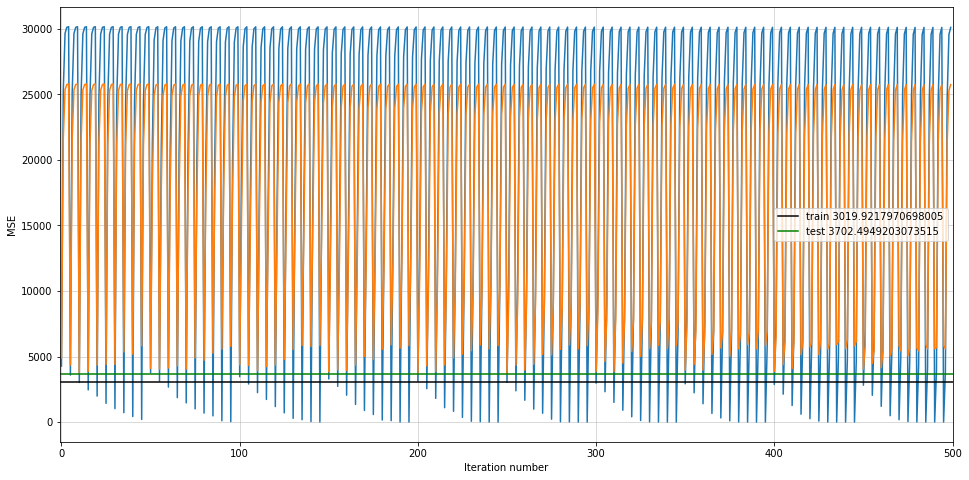

In [12]:
plt.figure(figsize = (16, 8))
plt.plot(range(len(train_list)), train_list)
plt.plot(range(len(test_list)), test_list)
plt.xlim(-1, 500)

plt.plot([0, 500], [b_train, b_train], label=f"train {b_train}", color='black')
plt.plot([0, 500], [b_test, b_test], label=f"test {b_test}", color='green')
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.legend()
plt.grid(alpha=0.6)

Градиентный бустинг сильно переобучается на тренировочной выборке в зависимости от глубины дерева, а также он переобучается в зависимости от количества деревьев, но при минимальной глубине дерева с увеличенивем количества деревьев его переобучение происходит медленее. Подбор только гиперпараметров n_trees(n_estimators), max_depth, eta не приводит к уменьшению MSE.

#### Задание 2: (опция) . Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [15]:
import random
def gb_fit_stochastic(iterations, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    n_batch = X_train.shape[0] // 2
    n_batch_test = X_test.shape[0] // 2
    
    for ii in range(1, iterations+1):
        
        train_errors_local = []
        test_errors_local = []
        trees_local = []

        for i in range(n_trees):
            one_X, one_y = X_train[0:n_batch],  y_train[0:n_batch]
            two_X, two_y = X_train[n_batch:-1], y_train[n_batch:-1]
            part = random.choice([[one_X, one_y], [two_X, two_y]])
            X_train_part = part[0]
            y_train_part = part[1]

            one_X2, one_y2 = X_test[0:n_batch_test],  y_test[0:n_batch_test]
            two_X2, two_y2 = X_test[n_batch_test:-1], y_test[n_batch_test:-1]
            part2 = random.choice([[one_X2, one_y2], [two_X2, two_y2]])
            X_test_part = part2[0]
            y_test_part = part2[1]
            
            
            tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(trees) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train_part, y_train_part)

                train_errors_local.append(mean_squared_error(y_train_part, gb_predict(X_train_part, trees, coefs, eta)))
                test_errors_local.append(mean_squared_error(y_test_part, gb_predict(X_test_part, trees, coefs, eta)))
            else:
                # Получим ответы на текущей композиции
                target = gb_predict(X_train, trees, coefs, eta)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, bias(y_train, target))

                train_errors_local.append(mean_squared_error(y_train_part, gb_predict(X_train_part, trees, coefs, eta)))
                test_errors_local.append(mean_squared_error(y_test_part, gb_predict(X_test_part, trees, coefs, eta)))
            
            trees_local.append(tree)

        train_errors.append(min(train_errors_local))
        test_errors.append(min(test_errors_local))
        trees.append( trees_local[np.argmin(train_errors_local)] )
        
        train_errors_local.clear()
        test_errors_local.clear()
        trees_local.clear()
            
        
    return trees, train_errors, test_errors

In [18]:
train_listt = []
test_listt = []
max_depth = 2
n_trees = 10
eta = 1
coefs = [1] * n_trees

for iterations in range(1, 21):
    trees, train_errors, test_errors = gb_fit_stochastic(iterations, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta) 
    train_listt.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
    test_listt.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
    

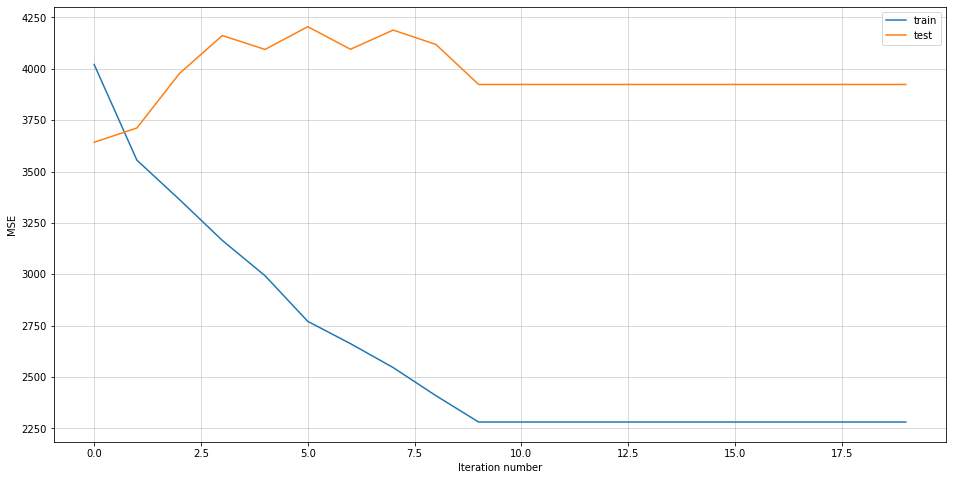

In [19]:
plt.figure(figsize = (16, 8))
plt.plot(range(len(train_listt)), train_listt, label='train')
plt.plot(range(len(test_listt)), test_listt,  label='test')

plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.legend()
plt.grid(alpha=0.6)